<h1 style="font-size:30px;">Introduction to the TensorFlow Data API</h1>

Thus far, we have been using the `image_dataset_from_directory()` class in TensorFlow to build data pipelines for training deep learning models. `image_dataset_from_directory()` is easy and straightforward to use but has some performance limitations and is not as flexible as other methods that can be used to create data pipelines. In this notebook, we will introduce how to use the <a href="https://www.tensorflow.org/guide/data" target=_blank>TensorFlow Data API</a> (`tf.data`), directly which has more flexibility and performance to handle larger datasets and a wide range of data formats. 

Specifically, we will create data pipelines using data that resides in memory and from data that resides on the filesystem. For this purpose, we will use the <a href="https://www.tensorflow.org/api_docs/python/tf/data/Dataset" target=_blank>tf.data.Dataset</a> class which has the following methods for processing data from memory and from the file system:

1. `tf.data.Dataset.from_tensor_slices()`
2. `tf.data.Dataset.list_files()` and `tf.data.Dataset.map()`



## Table of Contents
* [1 System Configuration](#1-System-Configuration)
* [2 Training and Dataset Configurations](#2-Training-and-Dataset-Configurations)
* [3 Download and Extract the Dataset](#3-Download-and-Extract-the-Dataset)
* [4 LeNet5 Model](#4-LeNet5-Model)
* [5 Data Pipeline from Memory](#5-Data-Pipeline-from-Memory)
* [6 Data Pipeline from File System](#6-Data-Pipeline-from-File-System)
* [7 Training Plots](#7-Training-Plots)
* [8 Conclusion](#8-Conclusion)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import requests
import zipfile
import pathlib

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Conv2D, Activation, Input,
                                     MaxPool2D, Flatten, Dense)

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

from tensorflow.keras.utils import to_categorical

block_plot = False

## 1 System Configuration

In [ ]:
def system_config(SEED_VALUE):

    np.random.seed(SEED_VALUE)
    tf.random.set_seed(SEED_VALUE)
    
    # Get list of GPUs.
    gpu_devices = tf.config.list_physical_devices('GPU')
    print(gpu_devices)
    
    if len(gpu_devices) > 0:
        print('Using GPU')
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
        
        # If there are any gpu devices, use first gpu.
        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
        
        # Grow the memory usage as it is needed by the process.
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        
        # Enable using cudNN.
        os.environ['TF_USE_CUDNN'] = "true"
    else:
        print('Using CPU')

system_config(7)

[]
Using CPU


## 2 Training and Dataset Configurations

In [ ]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 10
    IMG_HEIGHT:  int = 32
    IMG_WIDTH:   int = 32

@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:      int = 16
    EPOCHS:          int = 11
    LEARNING_RATE: float = 0.0005
    ROOT_LOG_DIR         = "./logs"
    ROOT_CHECKPOINT_DIR  = "./models"

## 3 Download and Extract the Dataset

As mentioned above, we will demonstrate how to create data pipelines from data that resides in memory and from data that resides on the file system. In this section, we will download the CIFAR10 dataset to our file system so it is avaialble for us to process. This CIFAR10 dataset has been downloaded from <a href="https://pjreddie.com/projects/cifar-10-dataset-mirror/" target=_blank>Joseph Redmon's website</a> and modified such that all the images are in their respective class folders.

In [ ]:
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)

In [ ]:
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

In [ ]:
download_file(
    'https://www.dropbox.com/s/6jrhe7uu4a4qxbn/cifar10.zip?dl=1',
    'cifar10.zip'
)
    
unzip(zip_file='cifar10.zip')

Extracted all


```
cifar10
├── labels.txt
├── test
│   ├── airplane
│   ├── automobile
│   ├── bird
│   ├── cat
│   ├── deer
│   ├── dog
│   ├── frog
│   ├── horse
│   ├── ship
│   └── truck
└── train
    ├── airplane
    ├── automobile
    ├── bird
    ├── cat
    ├── deer
    ├── dog
    ├── frog
    ├── horse
    ├── ship
    └── truck
```

As you can see, we have `train` and `test` subdirectories which in turn contain sub-directories for each class in the CIFAR10 dataset. All the class folders contain the respective images.

## 4 LeNet5 Model

In [ ]:
def LeNet5_model(num_classes, shape, print_model_summary=True):

    inputs = Input(shape=shape)
    
    # -------------------------------------
    # First convolutional Layer + pooling
    # -------------------------------------
    x = Conv2D(6, 5, padding='valid')(inputs)              # input size = (32, 32), output size = (28, 28)
    x = Activation("relu")(x)                              # output size = (28, 28)
    x = MaxPool2D()(x)                                     # output size = (14, 14)

    # -------------------------------------
    # Second convolutional layer + pooling 
    # -------------------------------------
    x = Conv2D(16, 5, padding='valid')(x)                  # input size = (14, 14), output size = (10, 10)
    x = Activation('relu')(x)                              # output size = (10, 10)
    feature_extractor_output = MaxPool2D()(x)              # output size = (5, 5)

    # Flatten.
    flattened = Flatten()(feature_extractor_output)        # 5 * 5 * 16 -> 400

    # ------------------------- 
    # Fully connected layers.
    # -------------------------
    x = Dense(120, activation='relu')(flattened)           # 400 -> 120
    x = Dense(84, activation='relu')(x)                    # 120 -> 84
    
    # Softmax output layer.
    headout = Dense(num_classes, activation="softmax")(x)  # 84 -> 10
    
    # Create model.
    model = Model(inputs=inputs, outputs=headout, name='LeNet5')
    
    if print_model_summary:
        model.summary()
        
    return model

In [ ]:
model = LeNet5_model(num_classes=DatasetConfig.NUM_CLASSES, 
                     shape=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, 3))

Model: "LeNet5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         456       
                                                                 
 activation (Activation)     (None, 28, 28, 6)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 activation_1 (Activation)   (None, 10, 10, 16)        0         
                                                            

2022-07-23 12:24:01.773852: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 5 Data Pipeline from Memory 

In this section, we are going to demonstrate how to create a data pipeline from data that resides in memory. For that purpose, we will load the CIFAR10 dataset into memory and then build a data pipeline from the data in memory. As a preview, we will create two convenience functions and use them to build the pipeline. The first function `cifar10_from_keras()` will load the dataset into memory, and the second function `prepare_input_pipeline()` will use `tf.data.Dataset.from_tensor_slices()` to build the data pipeline.

#### Load the CIFAR10 data into memory
`(X_train, y_train), (X_valid, y_test) = cifar10_from_keras()`

#### Prepare the tf.data pipeline data from memory
`train_ds = prepare_input_pipeline(X_train, y_train)` <br>
`valid_ds = prepare_input_pipeline(X_test, y_test)`

With that preview, let's now take a look at each of these functions.

### 5.1 Function to Load Dataset in Memory

The function below loads the CIFAR10 dataset from `Keras.datasets` into NumPy arrays and performs some pre-processing on the data to normalize the images and convert the labels to a one-hot encoded representation.

In [ ]:
# Function to load the CIFAR10 dataset from Keras Datasets.
def cifar10_from_keras():
    
    # load_data() returns NumPy arrays with Shape: (samples, height, width, channels)
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
    
    # Normalize images.
    X_train = X_train / 255.
    X_test = X_test / 255.
    
    num_classes = y_train.shape[-1]
    y_train = to_categorical(y_train, DatasetConfig.NUM_CLASSES)
    y_test = to_categorical(y_test, DatasetConfig.NUM_CLASSES)
        
    return (X_train, y_train), (X_test, y_test)

### 5.2 Function to Create Pre-fetch Dataset from Memory

The next function below uses `tf.data.Dataset.from_tensor_slices()` to load the image and label tensors into a dataset whose elements are slices of the given tensors. The inputs are sliced along their first dimension, which preserves the structure of the input, removing the first dimension of each tensor and using it as the dataset dimension. 

In [ ]:
def prepare_input_pipeline(x, y):
    
    # Create a TensorSliceDataset object.
    # x:  (samples, height, width, channels)
    # y:  (samples, classes)
    # ds: {samples} ((height, width, channels), (classes,))
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    
    # Optional, but highly recommended for improved performance. 
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=512)
    ds = ds.batch(TrainingConfig.BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    
    return ds

Ok, now let's try to understand what is happening in the above code block. In the `prepare_input_pipeline()`:
* We pass the images and labels as NumPy arrays to the function.
* As discussed we use the `tf.data.Dataset.from_tensor_slices` to prepare the `dataset`. This contains the data examples as images and their corresponding labels.

The next few lines of code are optional but can improve performance.
* `cache()`: Before loading the data in memory and shuffling it, we cache the data. This will improve performance by minimizing operations (like data reading) from being executed during each epoch.
* `shuffle`:  Randomly shuffles the elements of the dataset. `buffer_size` signifies how many data points to use at once. You need to be a bit careful with this as too large a `buffer_size` can potentially freeze your system if you run out of memory. 512, or 1024 provides a good balance.
* `batch`: This is the batch size to use for the training epochs.
* `prefetch`: Prefetching overlaps the preprocessing and model execution of a training step. While the model is executing training step s, the input pipeline is reading the data for step s+1. It can be used to decouple the time when data is produced from the time when data is consumed. The number of elements to prefetch can be managed by passing  `tf.data.AUTOTUNE`.
 
 

### 5.3 Load the Dataset in Memory and Create the Data Pipeline

We will now use the two functions above to load the data in memory and create a data pipeline. Note that although the dataset is partitioned into train and test components, for demonstration purposes, we will simply use the test data as the validation dataset. 

In [ ]:
# Load the CIFAR10 data into memory.
(X_train, y_train), (X_test, y_test) = cifar10_from_keras()

# Prepare the tf.data pipeline data from memory.
train_ds = prepare_input_pipeline(X_train, y_train)
valid_ds = prepare_input_pipeline(X_test, y_test)

### 5.5 Compile and Train the Model

In [ ]:
# Compile the model for experiment 1.
model = LeNet5_model(num_classes=DatasetConfig.NUM_CLASSES, 
                     shape=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, 3),
                     print_model_summary=False)

model.compile(optimizer=tf.keras.optimizers.Adam(TrainingConfig.LEARNING_RATE), 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy']
             )

# Train experiment 1.
print('TRAINING FROM LOADING TF.DATA DATASET FROM MEMORY')
history_1 = model.fit(train_ds,
                      epochs=TrainingConfig.EPOCHS,
                      validation_data=valid_ds,
                     )

TRAINING FROM LOADING TF.DATA DATASET FROM MEMORY
Epoch 1/11
3125/3125 [==============================] - 16s 5ms/step - loss: 1.6105 - accuracy: 0.4152 - val_loss: 1.4704 - val_accuracy: 0.4709
Epoch 2/11
3125/3125 [==============================] - 15s 5ms/step - loss: 1.3493 - accuracy: 0.5129 - val_loss: 1.2931 - val_accuracy: 0.5324
Epoch 3/11
3125/3125 [==============================] - 16s 5ms/step - loss: 1.2470 - accuracy: 0.5561 - val_loss: 1.2964 - val_accuracy: 0.5418
Epoch 4/11
3125/3125 [==============================] - 17s 5ms/step - loss: 1.1778 - accuracy: 0.5808 - val_loss: 1.2347 - val_accuracy: 0.5666
Epoch 5/11
3125/3125 [==============================] - 17s 5ms/step - loss: 1.1195 - accuracy: 0.6022 - val_loss: 1.1937 - val_accuracy: 0.5784
Epoch 6/11
3125/3125 [==============================] - 17s 5ms/step - loss: 1.0705 - accuracy: 0.6218 - val_loss: 1.1301 - val_accuracy: 0.6017
Epoch 7/11
3125/3125 [==============================] - 17s 5ms/step - loss: 1.0

## 6 Data Pipeline from File System

Creating a data pipeline from data that resides on the file system requires two methods from the TensorFlow Data API.

`tf.data.Dataset.list_files(path)`<br/>
`tf.data.Dataset.map(map_func)`

We first use `tf.data.Dataset.list_files()` to create a dataset object that contains file path references to the image files on disk. We then use the `tf.data.Dataset.map()` method which allows us to apply a user-defined function to process the images files on disk.

First, we define the list of class names for the CIFAR10 dataset and specify he root path for the dataset on the file system.

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
# Define the root path.
cifar10_root = pathlib.Path('./cifar10')

### 6.1 Using `tf.data.Dataset.list_files()` to Create List Datasets

Here, we use glob notation to obtain the path names to each image file in the dataset, and the `list_files()` method returns a`shuffleDataset` object that contains the pathnames stores as TensorFlow strings. Informally, we'll also refer to these objects as list datasets since they contain the list of pathnames to the image files.

In [ ]:
# Create the train and validation list datasets and check a few samples.
train_list_ds = tf.data.Dataset.list_files(os.path.join(cifar10_root, 'train', '*', '*'))
valid_list_ds = tf.data.Dataset.list_files(os.path.join(cifar10_root, 'test',  '*', '*'))

# Print a few entries from train_list_ds.
for file in train_list_ds.take(5):
    print(file)

tf.Tensor(b'cifar10/train/ship/46944_ship.png', shape=(), dtype=string)
tf.Tensor(b'cifar10/train/truck/44836_truck.png', shape=(), dtype=string)
tf.Tensor(b'cifar10/train/automobile/28957_automobile.png', shape=(), dtype=string)
tf.Tensor(b'cifar10/train/truck/43112_truck.png', shape=(), dtype=string)
tf.Tensor(b'cifar10/train/cat/39885_cat.png', shape=(), dtype=string)


### 6.2 Define a Function to Process the Image Files in the List Datasets

Next, we need to define a function that will process each of the image files in the list datasets we created above. The input signature of the function below is determined by the structure of each element in the list dataset (which is a file path to an image file). 

The function reads the image, decodes it from byte strings, and converts it to a `float32` tensor format. Next, we parse the file path to retrieve the class name (label) for the image sample. We then compare the `class_name` to the `class_names` list, which returns a boolean tensor which is then passed to the `argmax` function to determine the class ID (0-9).

In [ ]:
def process_path(file_path):

    raw = tf.io.read_file(file_path)
    image = tf.io.decode_image(raw)
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # Parse the file path to retrieve the class name.
    class_name = tf.strings.split(file_path, os.sep)[-2]
    
    # Compare the class name to the class names list to dertermine the class ID.
    one_hot = class_name == class_names
    label = tf.argmax(one_hot)
    
    return image, label

### 6.3 Apply the Mapping Function to the List Dataset

In [ ]:
# Apply the mapping function to the list datasets.
train_ds = train_list_ds.map(process_path)
valid_ds = valid_list_ds.map(process_path)

# Optional, but highly recommended for improved performance. 
train_ds = (train_ds
            .cache()
            .shuffle(buffer_size=512)
            .batch(TrainingConfig.BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE)
           )

valid_ds = valid_ds.batch(batch_size=TrainingConfig.BATCH_SIZE)

### 6.4 Compile and Train the Model

In [ ]:
# Compile the model for experiment 2.
model = LeNet5_model(num_classes=DatasetConfig.NUM_CLASSES, 
                     shape=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, 3))

model.compile(optimizer=tf.keras.optimizers.Adam(TrainingConfig.LEARNING_RATE),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'],
             )

# Train experiment 2.
print('\nTRAINING FROM LOADING TF.DATA DATASET FROM DISK')

history_2 = model.fit(train_ds,
                      epochs=TrainingConfig.EPOCHS,
                      validation_data=valid_ds,
                     )

Model: "LeNet5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 6)         456       
                                                                 
 activation_4 (Activation)   (None, 28, 28, 6)         0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 6)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 activation_5 (Activation)   (None, 10, 10, 16)        0         
                                                            

## 7 Training Plots

In [ ]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
    
    fig, ax = plt.subplots(figsize=(15, 5))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
        
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
    
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show(block=block_plot)
    plt.close()

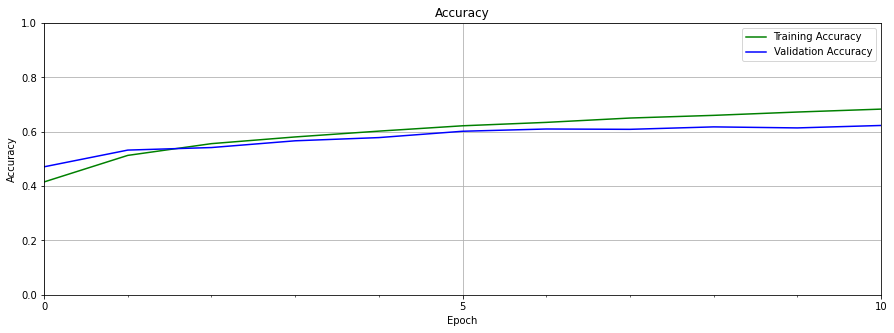

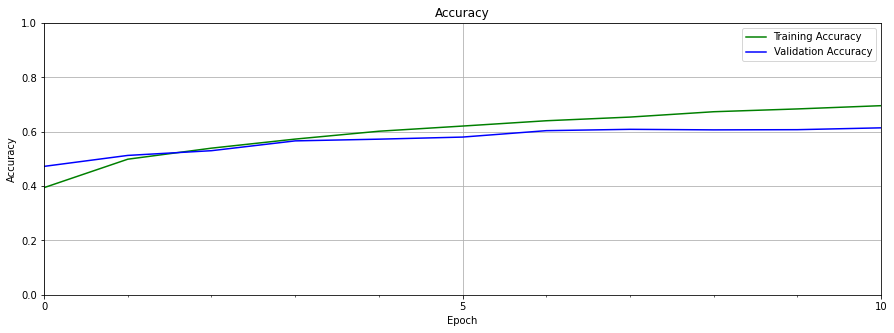

In [ ]:
train_acc = history_1.history["accuracy"]
valid_acc = history_1.history["val_accuracy"]

plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

train_acc = history_2.history["accuracy"]
valid_acc = history_2.history["val_accuracy"]

plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

## 8 Conclusion
In this notebook, we learned how to use the `tf.data` API to build efficient input data pipelines for image data using `tf.data.Datasets`. We demonstrated how to do this from data stored in memory as well as for data that resides on the file system. In the next notebook, we'll demonstrate how to use the Sequence class in TensorFlow to create a custom data loader class that will be very helpful in the next module when we cover image segmentation.